<h1>MLTS Exercise 10 - Transformer (Encoder-only) Training</h1>

Your task is to train a Transformer network on the electic power consumption dataset. The goal is to forcast values for the next day based on the mesurement values from a fixed window over the data from previous days.

The dataset can be downloaded from [Individual Household Electric Power Consumption](https://archive.ics.uci.edu/dataset/235/individual+household+electric+power+consumption)

It contains "Measurements of electric power consumption in one household with a one-minute sampling rate over a period of almost 4 years. Different electrical quantities and some sub-metering values are available."

**Dataset Reference**  
Hebrail, G. & Berard, A. (2006). Individual Household Electric Power Consumption [Dataset]. UCI Machine Learning Repository. https://doi.org/10.24432/C58K54.

In [1]:
# import packages
import pandas as pd
import matplotlib.pyplot as plt
from sklearn.preprocessing import MinMaxScaler
import numpy as np
import torch
import torch.nn as nn
from torch.utils.data import DataLoader, TensorDataset

from positional_encoding_standard import PositionalEncoding

In [2]:
# Set random seed for reproducibility
seed = 42
np.random.seed(seed)
torch.manual_seed(seed)
if torch.cuda.is_available():
    torch.cuda.manual_seed_all(seed)

### Load the dataset

In [3]:
# Importing dataset
path = '../08_09_RNN_LSTM/data/household_power_consumption.txt'

Household_consumption = pd.read_csv(path, sep=';', low_memory=False)
# Household_consumption

## Preprocess Data for training

For our model, we just use the `Global_active_power` as a timeseries which we want to forcast. Therefore, we drop the other columns beforehand.

Tasks:
* Drop all columns except `Date`, `Time` and `Global_active_power`
* Convert seperate date and time columns into datetime column
* Convert numeric columns to correct type
* Find and replace missing values

In [4]:
# Drop unneeded columns
Household_consumption.drop(columns=[
    'Global_reactive_power', 'Voltage',
    'Global_intensity', 'Sub_metering_1', 'Sub_metering_2', 'Sub_metering_3'], inplace=True)

In [5]:
# Parsing date and time into a single datetime column
Household_consumption['Datetime'] = pd.to_datetime(
    Household_consumption['Date'] + ' ' + Household_consumption['Time'], 
    format='%d/%m/%Y %H:%M:%S',
    errors='coerce'
)
# Drop date and time column
Household_consumption.drop(columns=['Date', 'Time'], inplace=True)
# Drop rows with missing datetime
Household_consumption.dropna(subset=['Datetime'], inplace=True)

In [6]:
# Convert numerical columns to numeric type
numeric_column = 'Global_active_power'
Household_consumption[numeric_column] = pd.to_numeric(Household_consumption[numeric_column], errors='coerce')

# Household_consumption.head(3)

In [7]:
# Find missing values
missing_values = Household_consumption.isnull().sum()
print("Missing values per column:\n", missing_values)

# Fill missing values with median for simplicity
Household_consumption[numeric_column] = Household_consumption[numeric_column].fillna(
    Household_consumption[numeric_column].median()
)

Missing values per column:
 Global_active_power    25979
Datetime                   0
dtype: int64


## Prepare the datasets for training

We want to forcased the mean value of the next day given the previous mean values. Therefore we need to resample our data to only contain one value per day.  

This will make training fast and it should therefore also work on your laptops CPU. Additionally, you can train the model on Google Colab or on in the CIP pool.

In [8]:
# Resample data to dayly intervals, calculating the mean for each day

Household_consumption_daily = (
    Household_consumption
    .resample('D', on='Datetime')  # Resample by day using the datetime column
    .mean(numeric_only=True)       # Ensure only numeric columns are aggregated
)

#check for missing values
missing_values_daily = Household_consumption_daily.isnull().sum()
print("Missing values per column:\n", missing_values_daily)
# Drop rows with missing values after resampling, if necessary
Household_consumption_daily.dropna(inplace=True)

Household_consumption_daily.head(3)

Missing values per column:
 Global_active_power    0
dtype: int64


,Global_active_power
Datetime,
2006-12-16,3.053475
2006-12-17,2.354486
2006-12-18,1.530435


Plot the data

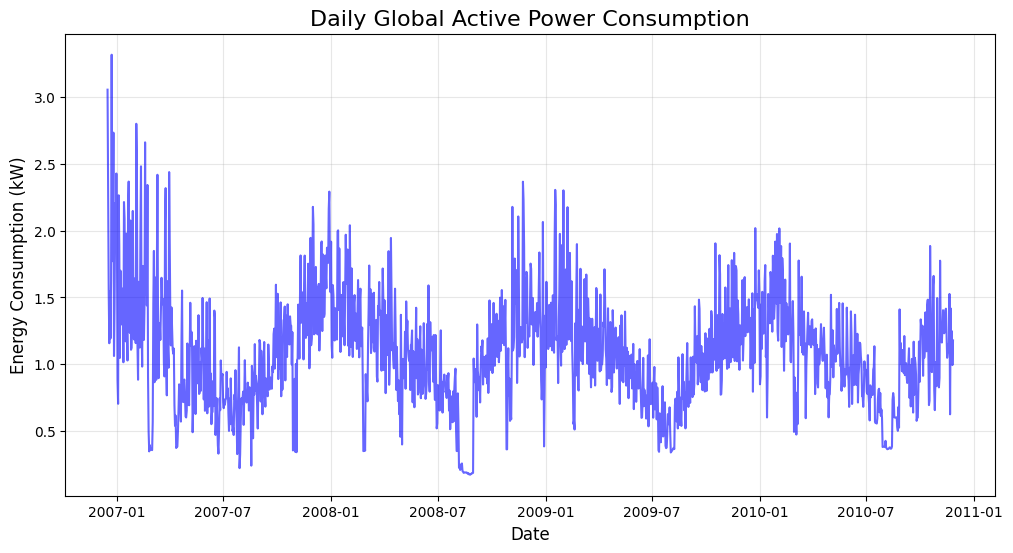

In [9]:
daily_data_week = Household_consumption_daily['Global_active_power']

# Plot daily trends and rolling average
plt.figure(figsize=(12, 6))
plt.plot(daily_data_week.index, daily_data_week, label="Daily Global Active Power", color='blue', alpha=0.6)
plt.title("Daily Global Active Power Consumption", fontsize=16)
plt.xlabel("Date", fontsize=12)
plt.ylabel("Energy Consumption (kW)", fontsize=12)
plt.grid(alpha=0.3)
plt.show()

#### Scale the data between 0 and 1

Normalizing or scaling the data is an important step before using the data for training as high raw values can often cause exploding gradients during training.

In [10]:
# Initialize the MinMaxScaler
scaler = MinMaxScaler()

# Apply the scaler to the selected features
Household_consumption_daily['Global_active_power_transformed'] = scaler.fit_transform(
    Household_consumption_daily[['Global_active_power']]
)

# Print a preview of the normalized data
Household_consumption_daily.head(3)

,Global_active_power,Global_active_power_transformed
Datetime,,
2006-12-16,3.053475,0.916786
2006-12-17,2.354486,0.694252
2006-12-18,1.530435,0.431901


#### Convert Time Series to Supervised Format

Time series data is sequential, but LSTMs require input-output pairs to learn patterns. By converting it into supervised format, we prepare the data so the model can learn from past observations to predict the future.

In [11]:
# Convert Time Series to Supervised Learning Format
def create_supervised_data(data: np.ndarray, lag: int) -> tuple[np.ndarray, np.ndarray]:
    """
    Convert time series data into supervised learning format.
    `lag` determines how many previous time steps are used.
    """
    X, y = [], []
    for i in range(lag, len(data)):
        X.append(data[i - lag:i])  # Previous `lag` steps
        y.append(data[i])       # Current step
    return np.array(X), np.array(y)

In [12]:
# Target column (e.g., 'Global_active_power')
target_column = Household_consumption_daily['Global_active_power_transformed'].values

# Use a lag of 30 (e.g., previous 30 time steps to predict the next step)
lag = 30
X, y = create_supervised_data(target_column, lag)

X.shape, y.shape

((1412, 30), (1412,))

#### Devide data into train and test set

We do not split train and test set randomly but by year. This will give us a better estimate at how the model could perform over a longer period of time that has not been seen in the trainings set.

For the test set, we will split away the last year of data, between '2010-01-01' and '2010-11-26'.  
Therefore, the train set will be all the data between '2006-12-16' and '2010-01-01'.

In [13]:
# Define the cutoff for the test set (e.g., one year)
test_start_date = '2010-01-01'  # Start of the test year
test_end_date = '2010-11-26'    # End of the test year

# Split data based on the dates
train_data = Household_consumption_daily.loc[:test_start_date].iloc[:-1]  # Up to the start of the test year
test_data = Household_consumption_daily.loc[test_start_date:test_end_date]  # The whole test year

# Extract the target column for both sets
train_target = train_data['Global_active_power_transformed'].values
test_target = test_data['Global_active_power_transformed'].values

# Create supervised learning format
X_train, y_train = create_supervised_data(train_target, lag)
X_test, y_test = create_supervised_data(test_target, lag)

# Reshape for LSTM input
X_train = X_train.reshape((X_train.shape[0], X_train.shape[1], 1))
X_test = X_test.reshape((X_test.shape[0], X_test.shape[1], 1))

# Print shapes for confirmation
print(f"X_train shape: {X_train.shape}")
print(f"y_train shape: {y_train.shape}")
print(f"X_test shape: {X_test.shape}")
print(f"y_test shape: {y_test.shape}")

X_train shape: (1082, 30, 1)
y_train shape: (1082,)
X_test shape: (300, 30, 1)
y_test shape: (300,)


## Task: Setup Transformer (Encoder-only) Model

Create your Transformer model here. You can either code it completely from scratch or use the already implemented models by pytorch.  

Nevertheless, think about how your inputs and outputs will look like and how the data is processed through the dataset. How do you need to implement the Transformer model?

In [14]:
class TransformerEncoderOnly(torch.nn.Module):

    def __init__(self,
                 input_dim: int = 1,
                 max_seq_len: int = 30,

                 n_layers: int = 1,
                 embed_size: int = 16,
                 n_heads: int = 4,
                 dim_feedforward: int = 2048,
                 dropout: float = 0.0):
        """
        Args:
            input_dim (int): Number of input features.
            max_seq_len (int): Max. Number of timesteps in each sequence.
            n_layers (int): Number of layers (Transformer).
            embed_size (int): The dimension for the input embedding.
            n_heads (int): Number of attention heads.
            dim_feedforward (int): Dimension of the transformer feedforward network.
            dropout (float): Dropout probability.
        """
        super().__init__()

        # Input Embedding: for one feature, we set in_channels=1.
        self.input_embedding = nn.Linear(input_dim, embed_size, bias=False)

        # Positional Encoding component.
        self.position_encoder = PositionalEncoding(d_model=embed_size, dropout=dropout, max_len=max_seq_len)

        # set up transformer encoder
        encoder_layers = nn.TransformerEncoderLayer(embed_size, n_heads, dim_feedforward, dropout, batch_first=True)
        self.encoder = nn.TransformerEncoder(encoder_layers, n_layers, enable_nested_tensor=False)

        # Regression heads: a series of linear layers.
        self.linear1 = nn.Linear(embed_size, 1)
        self.linear2 = nn.Linear(max_seq_len, 1)
        self.relu = nn.ReLU()

    def forward(self, x: torch.Tensor) -> torch.Tensor:
        """Forward pass

        Args:
            x (torch.Tensor): Input (batch, seq_len, input_dim)

        Returns:
            torch.Tensor: Output (batch)
        """
        # Embedd inputs (batch, seq_len, embed_size)
        x = self.input_embedding(x)

        # Apply positional encoding (batch, seq_len, embed_size)
        x = self.position_encoder(x)

        # Apply transformer encoder with source mask (batch, seq_len, embed_size)
        x = self.encoder(x)

        # # Regression head: linear layers with ReLU
        x = self.linear1(x)
        x = self.relu(x)
        x = self.linear2(x.squeeze(2))

        return x.squeeze(1)

Initialize Transformer model, the optimizer and the loss function. 

Loss function: MSELoss  
Optimizer: Adam

In [15]:
# Parameters
input_dim = 1

n_layers = 4
embed_size = 8
nhead = 1
dim_feedforward = 8

batch_size = 16
lr = 0.001

# Instantiate model
model = TransformerEncoderOnly(input_dim, lag, n_layers, embed_size, nhead, dim_feedforward)

# Define the loss function and optimizer
loss_fn = torch.nn.MSELoss()
optimizer = torch.optim.Adam(model.parameters(), lr=lr)

In [16]:
# Check for GPU availability
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")

# Move model to device
model = model.to(device)

#### Setup the dataloaders for the model

Convert the train and test set to torch, create a TorchDataset and a DataLoader for both

In [17]:
# Convert NumPy arrays to PyTorch tensors
X_train_tensor = torch.tensor(X_train, dtype=torch.float32)
y_train_tensor = torch.tensor(y_train, dtype=torch.float32)

X_test_tensor = torch.tensor(X_test, dtype=torch.float32)
y_test_tensor = torch.tensor(y_test, dtype=torch.float32)

# Print shapes to confirm
print(f"X_train_tensor shape: {X_train_tensor.shape}")
print(f"y_train_tensor shape: {y_train_tensor.shape}")
print(f"X_test_tensor shape: {X_test_tensor.shape}")
print(f"y_test_tensor shape: {y_test_tensor.shape}")

# Create TensorDataset for train and test sets
train_dataset = TensorDataset(X_train_tensor, y_train_tensor)
test_dataset = TensorDataset(X_test_tensor, y_test_tensor)

# Create DataLoader for batch processing
train_loader = DataLoader(train_dataset, batch_size=batch_size, shuffle=True)
test_loader = DataLoader(test_dataset, batch_size=batch_size, shuffle=False)

X_train_tensor shape: torch.Size([1082, 30, 1])
y_train_tensor shape: torch.Size([1082])
X_test_tensor shape: torch.Size([300, 30, 1])
y_test_tensor shape: torch.Size([300])


## Training/Testing Loop

Setup the training and test loop. Therefore, go through N epochs and in each epoch go through the data of your dataloader, pass the data to the model, calculate the loss and optimize the network. After each epoch, test the model on the test set by passing the data through the model and computing the loss. Save both test and train loss for later inspection

In [18]:
# Training parameters
num_epochs = 35  # Number of epochs for training

In [19]:
# Training loop
# Lists to track loss values
train_losses = []
test_losses = []

for epoch in range(num_epochs):
    model.train()  # Set the model to training mode
    train_loss = 0.0

    for X_batch, y_batch in train_loader:
        X_batch, y_batch = X_batch.to(device), y_batch.to(device)  # Move to device
        optimizer.zero_grad()

        # get predictions
        y_pred = model(X_batch)
        loss = loss_fn(y_pred, y_batch)

        loss.backward()
        optimizer.step()
        train_loss += loss.item()

    train_loss /= len(train_loader)
    train_losses.append(train_loss)  # Record train loss

    # Validation step
    model.eval()  # Set the model to evaluation mode
    test_loss = 0.0
    with torch.no_grad():
        for X_batch, y_batch in test_loader:
            X_batch, y_batch = X_batch.to(device), y_batch.to(device)  # Move to device

            y_pred = model(X_batch)
            loss = loss_fn(y_pred, y_batch)
            test_loss += loss.item()

    test_loss /= len(test_loader)
    test_losses.append(test_loss)  # Record test loss

    print(f"Epoch {epoch+1}/{num_epochs}, Train Loss: {train_loss:.4f}, Test Loss: {test_loss:.4f}")

Epoch 1/35, Train Loss: 0.0276, Test Loss: 0.0084
Epoch 2/35, Train Loss: 0.0135, Test Loss: 0.0080
Epoch 3/35, Train Loss: 0.0123, Test Loss: 0.0090
Epoch 4/35, Train Loss: 0.0121, Test Loss: 0.0076
Epoch 5/35, Train Loss: 0.0115, Test Loss: 0.0083
Epoch 6/35, Train Loss: 0.0116, Test Loss: 0.0070
Epoch 7/35, Train Loss: 0.0111, Test Loss: 0.0071
Epoch 8/35, Train Loss: 0.0106, Test Loss: 0.0066
Epoch 9/35, Train Loss: 0.0102, Test Loss: 0.0072
Epoch 10/35, Train Loss: 0.0098, Test Loss: 0.0074
Epoch 11/35, Train Loss: 0.0101, Test Loss: 0.0063
Epoch 12/35, Train Loss: 0.0094, Test Loss: 0.0070
Epoch 13/35, Train Loss: 0.0096, Test Loss: 0.0063
Epoch 14/35, Train Loss: 0.0092, Test Loss: 0.0061
Epoch 15/35, Train Loss: 0.0089, Test Loss: 0.0061
Epoch 16/35, Train Loss: 0.0091, Test Loss: 0.0070
Epoch 17/35, Train Loss: 0.0088, Test Loss: 0.0071
Epoch 18/35, Train Loss: 0.0093, Test Loss: 0.0062
Epoch 19/35, Train Loss: 0.0089, Test Loss: 0.0079
Epoch 20/35, Train Loss: 0.0091, Test Lo

Display loss curves

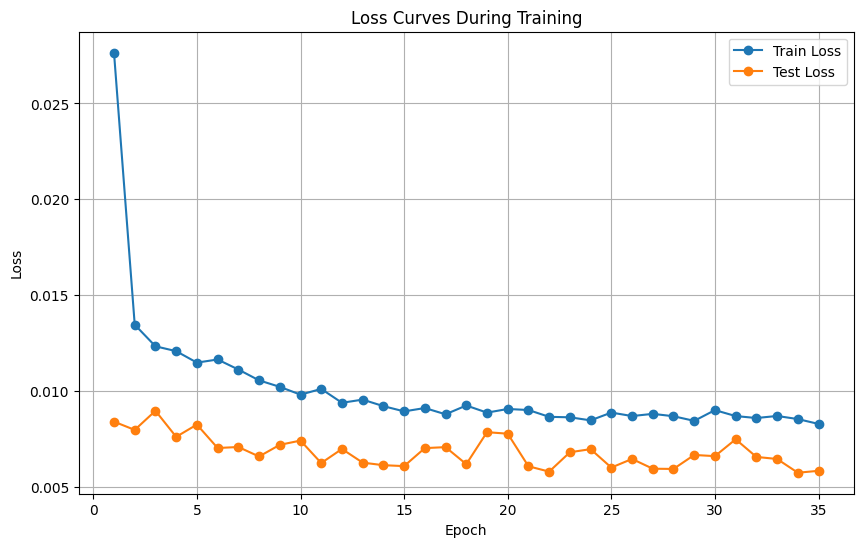

In [20]:
# Plot the loss curves
plt.figure(figsize=(10, 6))
plt.plot(range(1, num_epochs + 1), train_losses, label="Train Loss", marker='o')
plt.plot(range(1, num_epochs + 1), test_losses, label="Test Loss", marker='o')
plt.xlabel("Epoch")
plt.ylabel("Loss")
plt.title("Loss Curves During Training")
plt.legend()
plt.grid(True)
plt.show()

## Evaluation

Evaluate your trained model by comparing the ground truth data against the predicted time series values.

#### Ground Truth vs. Predicted Time Series

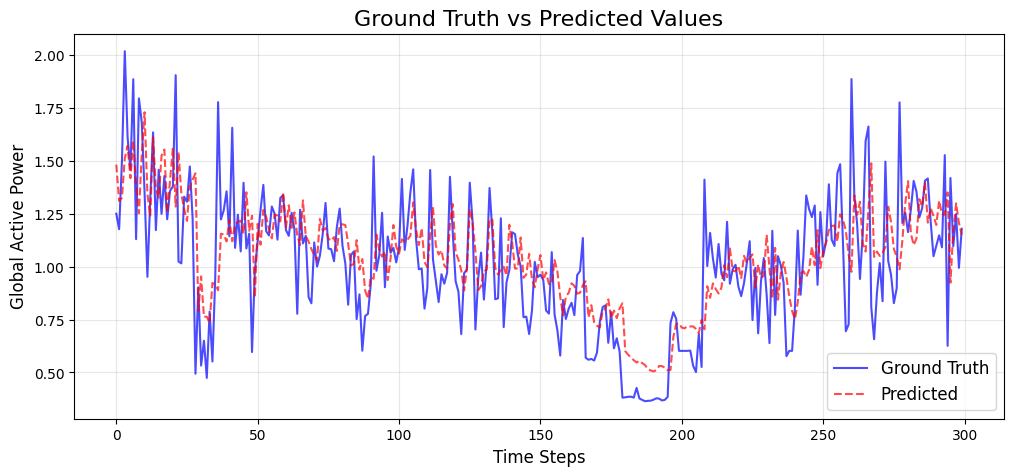

In [21]:
# Switch model to evaluation mode
model.eval()

# Generate predictions
with torch.no_grad():
    # Pass test inputs through the model
    y_pred_test = []

    for X_batch, y_batch in test_loader:
            X_batch, y_batch = X_batch.to(device), y_batch.to(device)  # Move to device
            y_pred = model(X_batch)
            y_pred_test.append(y_pred.cpu())

    y_pred_test = torch.concat(y_pred_test, dim=0).numpy()

# rescale predictions
rescaled_y_test = scaler.inverse_transform(y_test_tensor.numpy().reshape(-1, 1))
rescaled_y_pred = scaler.inverse_transform(y_pred_test.reshape(-1, 1))

# Plot Ground Truth vs Predictions
plt.figure(figsize=(12, 5))
plt.plot(rescaled_y_test, label="Ground Truth", color='blue', alpha=0.7)
plt.plot(rescaled_y_pred, label="Predicted", color='red', linestyle='--', alpha=0.7)
plt.title("Ground Truth vs Predicted Values", fontsize=16)
plt.xlabel("Time Steps", fontsize=12)
plt.ylabel("Global Active Power", fontsize=12)
plt.legend(fontsize=12)
plt.grid(alpha=0.3)
plt.show()

#### Long term forcasting

Additionally, we want to test if our model can do long term forcasting and predict correct values based on its previous predictions. Of course, our model is not designed and trained to do that specifically, but it is a good test how errors propagate over time and maybe gives us more ideas on how we could improve the model.

In [22]:
# Function for iterative prediction
def iterative_prediction(model, initial_input, num_steps):
    """
    Iteratively predict the future time steps using the Transformer model.
    
    Parameters:
    - model: Trained Transformer model.
    - initial_input: The input sequence for the first prediction (shape: [1, timesteps, features]).
    - num_steps: Number of future time steps to predict.
    
    Returns:
    - predictions: List of predictions for the future time steps.
    """
    model.eval()  # Set model to evaluation mode
    input_sequence = initial_input.clone()  # Clone to avoid modifying the original input
    predictions = []

    for _ in range(num_steps):
        with torch.no_grad():
            # Predict the next step
            next_step = model(input_sequence)
            
            # Append the prediction to the list
            predictions.append(next_step.item())
            
            # Prepare the next input
            next_input = torch.cat((input_sequence[:, 1:, :], next_step.reshape(-1, 1, 1)), dim=1)
            input_sequence = next_input

    return predictions

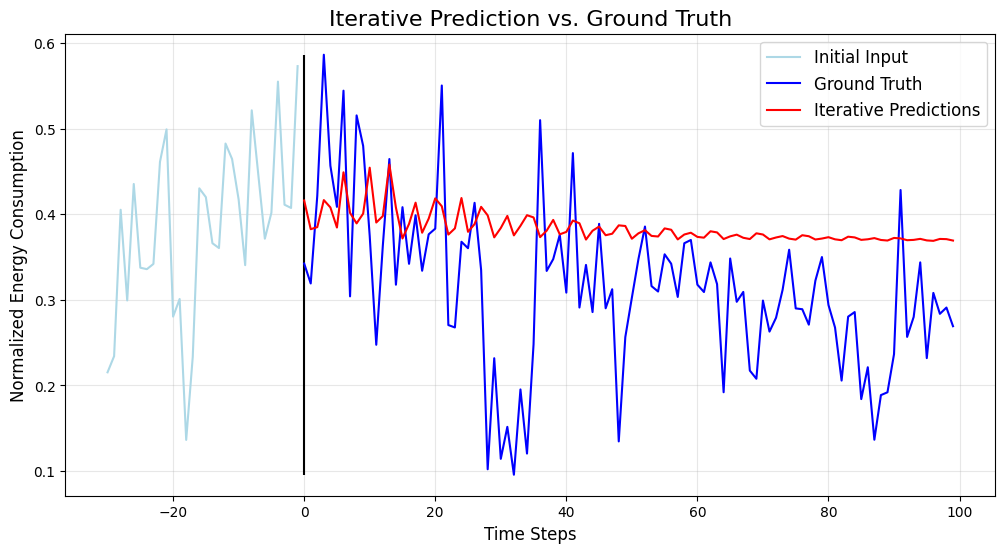

In [27]:
# Parameters for visualization
initial_input = X_test_tensor[0].unsqueeze(0).to(device)# Start with the first test sequence
num_steps = 100  # Number of steps to predict iteratively

# Get iterative predictions
iterative_predictions = iterative_prediction(model, initial_input, num_steps)

# Create a timeline for visualization
timeline = list(range(len(y_test_tensor[:num_steps])))

# Ground truth values for comparison
ground_truth = y_test_tensor[:num_steps].numpy()

# Plot the results
plt.figure(figsize=(12, 6))
plt.plot(list(range(-lag, 0, 1)), initial_input[0].cpu(), label="Initial Input", color='lightblue')
plt.vlines(0, min(ground_truth), max(ground_truth), colors='black')
plt.plot(timeline, ground_truth, label="Ground Truth", color='blue')
plt.plot(timeline, iterative_predictions, label="Iterative Predictions", color='red')
plt.title("Iterative Prediction vs. Ground Truth", fontsize=16)
plt.xlabel("Time Steps", fontsize=12)
plt.ylabel("Normalized Energy Consumption", fontsize=12)
plt.legend(fontsize=12)
plt.grid(alpha=0.3)
plt.show()

#### Questions:

* How well can the time series be predicted?
* How could the training be improved / changed?

Feel free to test out more ideas as you like!